# Levering World Events with iGAN

In [1]:
import sys
print(sys.executable)


/Users/kenneto/torch_m1_env/bin/python


## Import Functions

In [2]:
import sys
sys.path.append('.')
sys.path.append('../')
import os 
import os.path as path
import datetime
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from darts import TimeSeries
import plotly
import cufflinks as cf

import plotly.io as pio
pio.renderers.default = "notebook"
import cufflinks as cf
cf.go_offline(connected=True)

from plotly.offline import plot, download_plotlyjs, init_notebook_mode, iplot

from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
%load_ext autoreload
%autoreload 2

import config as proj_config
cache_path = proj_config.CACHE_DIR
data_path = proj_config.DATA_DIR
events_data_path = proj_config.EVENTS_DATASET_DIR
categories_path = cache_path + '/categories_events/'

from demand_prediction.general_functions import get_file_path, get_df_table, load_table_cache, save_table_cache, get_pred_dates
from demand_prediction.dataset_functions import split_data, create_events_df
from demand_prediction.events_models import load_events_model, save_events_model, calc_events_ts
from demand_prediction.lstm_models import get_lstm_results
from demand_prediction.results_functions import get_all_k_metrics


Seed set to 0


Parent class of EventRNNModel: (<class 'darts.models.forecasting.rnn_model.RNNModel'>,)


# Data

## Wikipedia Events Data

In [3]:
world_events = get_df_table("events/Base_events_5.0")
world_events.head()

Total data size:  13926


,date,country,Category,wiki_name,embedding,High-Category,views_on_event_day,label,type,global_relevance_rank,cosine_sim,view_seq,original_date
0,1980-01-03,India,general election,1980 Indian general election,"[-0.024715753, 0.16647163, 0.26061583, 0.38191...",PoliticalEvent,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1980-01-03
1,1980-01-04,France,unsolved crime,disappearance of Monique Réjembeau,"[0.049826637, 0.31028283, 0.35186794, 0.229728...",CriminalEvent,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1980-01-04
2,1980-01-07,United States of America,TennisTournament,1980 Avon Championships of Cincinnati,"[-0.7737418, 0.44452286, 0.44949022, -0.293493...",SportsEvent,NaN,NaN,NaN,NaN,NaN,NaN,1980-01-07
3,1980-01-11,Argentina,Formula One Grand Prix,1980 Argentine Grand Prix,"[-0.22531247, 0.27953282, 0.40557247, 0.049306...",SportsEvent,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1980-01-11
4,1980-01-14,United States of America,TennisTournament,1980 Birmingham Open,"[-0.3976065, -0.59886205, 1.0677863, 0.0126197...",SportsEvent,NaN,NaN,NaN,NaN,NaN,NaN,1980-01-14


## S&P 500 Data

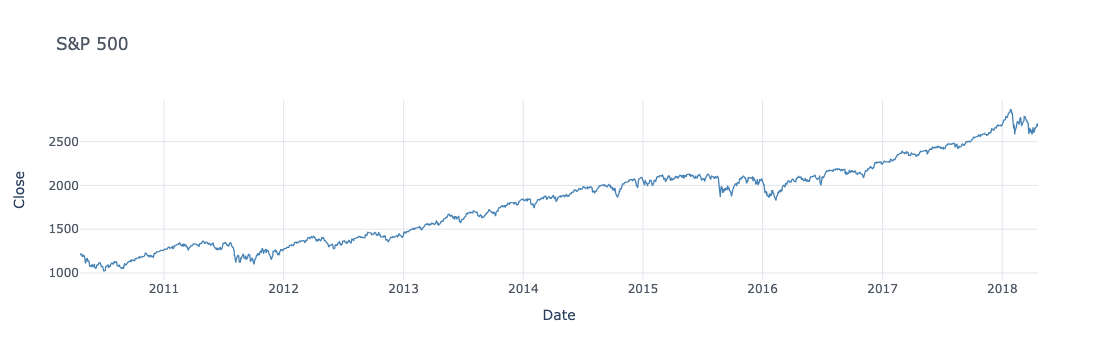

In [ ]:
csv_path = "../data/datasets/stocks/sp500_2010_2018.csv"
sp500_df = pd.read_csv(csv_path, parse_dates=['Date'])

sp500_df.rename(columns={'Date': 'date', 'Close': 'Quantity'}, inplace=True)

sp500_df = sp500_df[['date', 'Quantity']]
sp500_df.set_index('date', inplace=True)
sp500_df.sort_index(inplace=True)

sp500_df = sp500_df.fillna(method='ffill') # for missing

leaf_name = 'S&P 500'
fig = sp500_df[['Quantity']].iplot(asFigure=True, colors=['steelblue'])
fig.update_layout(
    title={'text': leaf_name},
    xaxis={'title': 'Date'},
    yaxis={'title': 'Close'}
)
fig.show()


Top 5 days with highest absolute residual values (2017-07-01 to 2018-04-20):
date
2018-02-08    165.849325
2018-02-09    123.739941
2018-01-26    114.997469
2018-02-05    105.557381
2018-01-29     95.383049
Name: Residual, dtype: float64


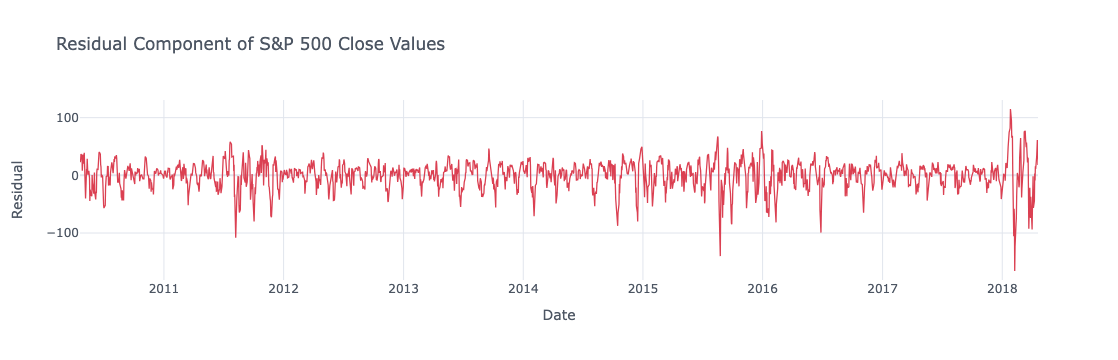

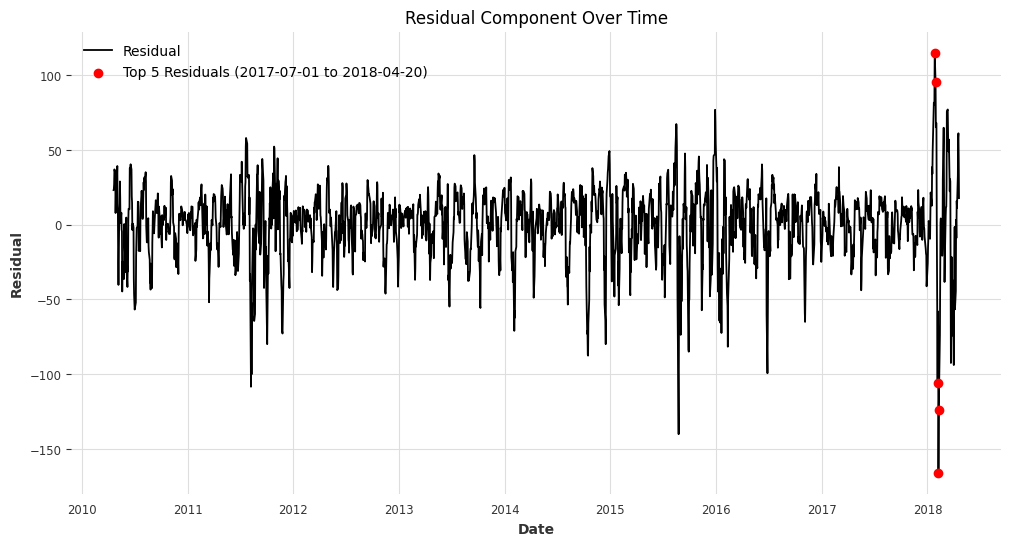

In [ ]:
# Compute the rolling mean and the deviation from mean (residual)
rolling_window = 30
res_df=sp500_df
res_df['Rolling_Mean'] = sp500_df['Quantity'].rolling(window=rolling_window, min_periods=1, center=True).mean()
res_df['Residual'] = sp500_df['Quantity'] - sp500_df['Rolling_Mean']

# Restrict df to test date range
start_date = pd.to_datetime('2017-07-01')
end_date = pd.to_datetime('2018-04-20')
filtered_df = res_df.loc[start_date:end_date]

# Identify 5 days with highest absolute residuals (within test date range)
top5_residuals = filtered_df['Residual'].abs().nlargest(5)
print("Top 5 days with highest absolute residual values (2017-07-01 to 2018-04-20):")
print(top5_residuals)

res_df[['Residual']].iplot(
    title='Residual Component of S&P 500 Close Values',
    xTitle='Date',
    yTitle='Residual',
    theme='white',
    colors=['red']
)

plt.figure(figsize=(12,6))
plt.plot(res_df.index, res_df['Residual'], label='Residual')
plt.scatter(top5_residuals.index, sp500_df.loc[top5_residuals.index, 'Residual'], 
            color='red', zorder=5, label='Top 5 Residuals (2017-07-01 to 2018-04-20)')
plt.title('Residual Component Over Time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()


# Hyper Parameters

In [ ]:
# Caching options
ts_cache = False 
lstm_cache = False
lstm_df_cache = False
results_cache = False 

n_in = 24
window_size = 30    
prediction_time = 30   
device = 'cpu'

use_covariates = True                              # switch to false for vanilla LSTM
model='GAN - Event LSTM'

#the following were experimented with but ultimately not used. These are for future work (metrics for relevance)
mode = ''                                  # choose between ['', 'multiply', 'concat']
concat_features = ['cosine_sim']        # only used if mode not '' ---->change to mode_feature
weighted_covariates = False
smoothing_lambda = 0
covariate_scaling = 1

# Dates Set up

In [ ]:
data = create_events_df(sp500_df, world_events, emb_only=True)
events_dates = list(set(data['date']))

sp500_df.index = pd.to_datetime(sp500_df.index)
print("Index type:", type(sp500_df.index))
print("Index dtype:", sp500_df.index.dtype)
print("Head of Price DataFrame:\n", sp500_df.head())

start_pred_list = get_pred_dates('2016-12-20', '2018-04-20')

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index dtype: datetime64[ns]
Head of Price DataFrame:
                Quantity  Rolling_Mean   Residual
date                                            
2010-04-20  1207.170044   1184.009334  23.160710
2010-04-21  1205.939941   1182.245628  23.694313
2010-04-22  1208.670044   1181.623535  27.046509
2010-04-23  1217.280029   1180.280002  37.000027
2010-04-26  1212.050049   1177.932636  34.117412


/Users/kenneto/Desktop/UoB/Dissertation/GAN-Event-main/src/demand_prediction/dataset_functions.py:49: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/kenneto/Desktop/UoB/Dissertation/GAN-Event-main/src/demand_prediction/dataset_functions.py:49: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [8]:
total_pred = pd.DataFrame()

# Training Loop

  0%|                                                    | 0/17 [00:00<?, ?it/s]

Train size: 2388  - Test size: 615
getting embeddings...
PRINTING EMBEDDINGS PATHS:/n
../../GAN-Event-main-original/GAN-Event/gan_embeddings/Gan_Embeddings_RNN_Feedback_7_train_gan_embeddings.pkl
../../GAN-Event-main-original/GAN-Event/gan_embeddings/Gan_Embeddings_RNN_Feedback_7_test_gan_embeddings.pkl
Initializing EventRNNModel ...


/Users/kenneto/Desktop/UoB/Dissertation/GAN-Event-main/src/../src/demand_prediction/gan_events.py:38: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/kenneto/Desktop/UoB/Dissertation/GAN-Event-main/src/../src/demand_prediction/gan_events.py:38: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/kenneto/Desktop/UoB/Dissertation/GAN-Event-main/src/../src/demand_prediction/gan_events.py:38: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

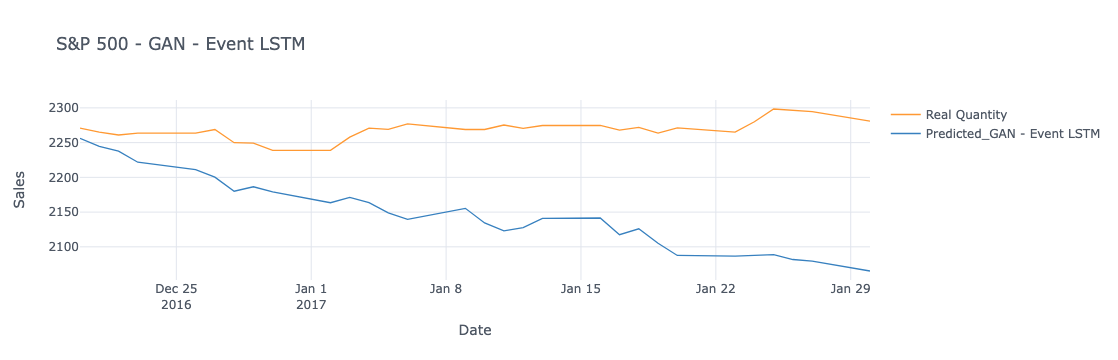

For start date 2016-12-20, lstm_predictions shape: (30, 1)
component   Predicted_GAN - Event LSTM
date                                  
2016-12-20                 2256.291016
2016-12-21                 2244.454590
2016-12-22                 2237.695557
2016-12-23                 2221.802246
2016-12-26                 2211.103760


  6%|██▎                                     | 1/17 [27:17<7:16:41, 1637.61s/it]

Train size: 2408  - Test size: 595
getting embeddings...


In [ ]:
import logging
logging.getLogger("darts").setLevel(logging.ERROR)
for start_pred_time in tqdm(start_pred_list): 
    pred_path = f"{cache_path}/saved_results/final_results_Economy_{start_pred_time}_predictions"
    
    # Split event-based data
    X_train, X_test = split_data(data, start_pred_time)
    
    # Create TimeSeries for prices:
    # (Fill missing dates, forward fill values, and ensure Business Day frequency)
    time_series = TimeSeries.from_dataframe(sp500_df, fill_missing_dates=True, freq='B', value_cols="Quantity")
    df_ts = time_series.pd_dataframe().fillna(method='ffill')
    time_series = TimeSeries.from_dataframe(df_ts, freq='B')
    
    # Split the price TimeSeries into train and test portions.
    train, test_ts = time_series.split_before(pd.Timestamp(start_pred_time))
    test = test_ts[:prediction_time]
    if len(test) < prediction_time:
        print(f"Skipping {start_pred_time}: only {len(test)} test rows available.")
        continue
    
    # Convert the train and test time series to DataFrames.
    train_df, test_df = train.pd_dataframe(), test.pd_dataframe()
    
    #the following section is reserved for future work (the Base_events dataset has zero values for these columns)
    # -------------------------------------------------------------------
    # Extract and normalize global_relevance_rank per date:
    if "global_relevance_rank" in data.columns and data["global_relevance_rank"].notnull().any():
        # Group by date and take mean of global_relevance_rank
        grr_series = data.groupby('date')['global_relevance_rank'].mean()

        # Normalize to [0,1] then shift to [1,2]
        grr_series = (grr_series - grr_series.min()) / (grr_series.max() - grr_series.min()) + 1
        grr_series.index = pd.to_datetime(grr_series.index)
        # Reindex onto train/test dates and forward-fill missing values
        train_grr = grr_series.reindex(pd.to_datetime(train_df.index), method='ffill').tolist()
        test_grr = grr_series.reindex(pd.to_datetime(test_df.index), method='ffill').tolist()
    else:
        print("Debug: No global_relevance_rank provided.")
        train_grr, test_grr = [], []
    # -------------------------------------------------------------------
    
    lstm_predictions = get_lstm_results(
                        train, test, train_df, test_df, train_grr, test_grr,
                        sp500_df, start_pred_time, leaf_name, n_in, window_size, device, 
                        lstm_df_cache, lstm_cache, use_covariates, mode, concat_features
                        )
    print(f"For start date {start_pred_time}, lstm_predictions shape: {lstm_predictions.shape}")
    print(lstm_predictions.head())


    os.makedirs(os.path.dirname(pred_path), exist_ok=True)
    lstm_predictions.to_pickle(pred_path)

    # Merge prediction and real vals
    actual_quantity = test_df[['Quantity']].rename(columns={'Quantity': 'Actual_Quantity'})
    pred_df = actual_quantity.merge(lstm_predictions, left_index=True, right_index=True, how='left')
    total_pred = pd.concat([total_pred, pred_df])
    os.makedirs(os.path.dirname(pred_path), exist_ok=True)
    total_pred.to_pickle(pred_path) # saving


# Final aggregation and evaluation

In [ ]:
total_pred = total_pred[total_pred.index >= start_pred_list[0]]
pred_columns = [col for col in total_pred.columns if col.startswith("Predicted_")]
if not pred_columns:
    raise ValueError("No predicted values found ... expected at least one 'Predicted_<Model_Name>' column.")

total_pred_agg = total_pred.groupby(total_pred.index).mean().sort_index()
df_eval = total_pred_agg

print("Aggregated Evaluation DataFrame head:")
print(df_eval.head())

pred_columns = [col for col in df_eval.columns if col.startswith("Predicted_")]

def compute_mae_wmape_at_k(df, actual_col, pred_col, k):
    df = df.copy()
    df['abs_error'] = (df[actual_col] - df[pred_col]).abs()
    df_top_k = df.nlargest(k, 'abs_error')
    mae_k = df_top_k['abs_error'].mean()
    wmape_k = df_top_k['abs_error'].sum() / df_top_k[actual_col].abs().sum()
    return mae_k, wmape_k

def compute_wmape_top_k_residuals(df, actual_col, pred_col, k):
    df = df.copy()
    df['residual'] = (df[actual_col] - df[pred_col]).abs()
    df_top_k = df.nlargest(k, 'residual')
    wmape_k = df_top_k['residual'].sum() / df_top_k[actual_col].abs().sum()
    return wmape_k


df_eval['residual'] = (df_eval['Actual_Quantity'] - df_eval[pred_columns[0]]).abs()
df_eval_sorted = df_eval.sort_values(by='residual', ascending=False)


K_values = [5, 10, 20, 100, 200, 300]

# Compute MAE and wMAPE for each K value
for pred_col in pred_columns:
    print(f"\n=== Results for {pred_col} ===")
    for k in K_values:
        df_top_k = df_eval_sorted.head(k)
        mae_k = df_top_k['residual'].mean()
        wmape_k = df_top_k['residual'].sum() / df_top_k['Actual_Quantity'].abs().sum()
        print(f"   MAE@{k}: {mae_k:.4f},  wMAPE@{k}: {wmape_k:.4f}")

fig = total_pred_agg[['Actual_Quantity'] + pred_columns].iplot(
    asFigure=True,
    title="S&P 500: GAN - Event LSTM",
    xTitle='Date',
    yTitle='Close',
    theme='white'
)
iplot(fig)